In [2]:
include("../src/PowerPhaseRetrieval.jl")
include("../src/core/topology_sensitivities.jl")
import .PowerPhaseRetrieval as PPR
using LinearAlgebra,PowerModels
using Statistics,Random,Distributions
using StatsPlots,LaTeXStrings,ColorSchemes
using JuMP,Ipopt
using DataFrames

┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.compute_basic_ac_pf! :: Tuple{Dict{String, Any}}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.calc_closest_rank_r :: Tuple{Matrix, Integer}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240


# Test the phase retrieval problem with a known and unknown topology

In [9]:
# ---------------- load case and run power flow
net = make_basic_network(parse_file("../data/networks/case_RTS_GMLC.m")) #basic network
pq_buses = PPR.calc_bus_idx_of_type(net,[1])
compute_ac_pf!(net)

# ----------------- get the initial values
v0 = calc_basic_bus_voltage(net)[pq_buses]
vm0 = abs.(calc_basic_bus_voltage(net)[pq_buses])
θ0 = angle.(calc_basic_bus_voltage(net)[pq_buses])
p0 = real.(calc_basic_bus_injection(net)[pq_buses])
q0 = imag.(calc_basic_bus_injection(net)[pq_buses])

# ----------------- get the topology data
Y = calc_basic_admittance_matrix(net)[pq_buses,pq_buses]
G,B = real.(Y),imag.(Y)

# ----------------- get the sensitivities (topology known)
dpθ_model,dqθ_model,dpvm_model,dqvm_model = calc_topology_sensitivities!(net,sel_bus_types=[1])
J_model = [
    dpθ_model dpvm_model;
    dqθ_model dqvm_model
]
y_topology = J_model*[θ0;vm0]

# ----------------- get the sensitivities (polar)
J_polar = PPR.calc_jacobian_matrix(net,[1])
J_polar_mat = Matrix(PPR.calc_jacobian_matrix(net,[1]).matrix)
x_polar_true = [θ0;vm0]
y_polar_true = J_polar_mat*x_polar_true


# ----------------- check that the topology-free and topology-based align
println("Jacobian error: ",norm(J_polar_mat-J_model))
println("Output error: ",norm(y_polar_true-y_topology))

Jacobian error: 1.3536423536960935e-13
Output error: 1.1687142233529766e-13


In [10]:
# ----------------- Function to perform model-based phase retrieval
function est_model_based_voltage_phase(sigma_noise;p_nom=p0,q_nom=q0,θ0=θ0,vm0=vm0)
    d_noise = Normal(0,sigma_noise)
    f_x_obs = J_model*[θ0;vm0] 
    noise = [rand(d_noise,length(p_nom));rand(d_noise,length(q_nom))]
    f_x_obs[.!(f_x_obs .≈ 0)] += noise[.!(f_x_obs .≈ 0)]
    x_hat = inv(Matrix(J_model))*f_x_obs
    return Dict(
        "th_hat"=>x_hat[1:length(θ0)],
        "th_rel_err"=>norm(x_hat[1:length(θ0)]-θ0)/norm(θ0)*100
    )    
end


est_model_based_voltage_phase (generic function with 1 method)

In [11]:
"""
Given a basic network data dict, compute AC power flow solution and retrieve the voltage phases
With a simulated "estimated" power-voltage magnitude sensitivites.
"""
function est_model_free_voltage_phase!(network::Dict{String,Any};sel_bus_types=[1],sigma_noise=0.25,sigma_jac=0.1)
    compute_ac_pf!(network)
    #----- Get relevant PQ bus indeces
    sel_bus_idx = PPR.calc_bus_idx_of_type(network,sel_bus_types)
    n_bus = length(sel_bus_idx) #Get num_bus
    Y = calc_basic_admittance_matrix(network)[sel_bus_idx,sel_bus_idx]

    # ---------- Compute nominal ground truth values/params
    #-Compute ground truth complex power injections
    rect_s_nom = calc_basic_bus_injection(network)[sel_bus_idx]
    p_nom,q_nom = real.(rect_s_nom),imag.(rect_s_nom)
    f_x_nom = [p_nom;q_nom]

    #-Compute ground truth Jacobians
    J_nom_model = PPR.calc_jacobian_matrix(network,sel_bus_types) #PQ buses only
    J_nom = Matrix(J_nom_model.matrix)
    ∂pθ_true,∂qθ_true = J_nom_model.pth,J_nom_model.qth #--- UNKNOWN angle blocks
    ∂pv_true,∂qv_true = J_nom_model.pv,J_nom_model.qv

    #-Compute ground truth voltages
    v_rect_nom = calc_basic_bus_voltage(network)[sel_bus_idx]
    vm_nom,va_nom = abs.(v_rect_nom),angle.(v_rect_nom)
    x_nom = [va_nom;vm_nom]
    # ----------

    #----- Compute  observed mismatches and voltage magnitudes
    #--- Compute noise parameters for the active and reactive power injections.
    d_noise = Normal(0,sigma_noise)
    noise = [rand(d_noise,length(p_nom));rand(d_noise,length(q_nom))]

    #--- Compute a random perturbation around the operating point,
    # noise distributions for p and q:
    f_x_obs = J_nom*x_nom 
    f_x_obs[.!(f_x_obs .≈ 0)] += noise[.!(f_x_obs .≈ 0)]
    p_obs,q_obs = f_x_obs[1:n_bus],f_x_obs[n_bus+1:end]
    vm_obs = (inv(J_nom)*f_x_obs)[n_bus+1:end]

    #---------- Simulate "estimated" jacobians -- add random noise
    #--- Standard Normal jac noise distribution
    d_jac = Normal(0,sigma_jac)
    noise_pv = rand(d_jac,n_bus,n_bus)
    noise_qv = rand(d_jac,n_bus,n_bus)
    ∂pv_obs = deepcopy(∂pv_true)
    ∂qv_obs =  deepcopy(∂qv_true)
    ∂pv_obs[.!(p_obs .≈ 0),:] += noise_pv[.!(p_obs .≈ 0),:]
    ∂qv_obs[.!(q_obs .≈ 0),:] += noise_qv[.!(q_obs .≈ 0),:]
    #∂pv_obs[.!(∂pv_true .≈ 0)] +=  noise_pv[.!(∂pv_true .≈ 0)] #rand(dist_pv,n_bus,n_bus)
    #∂qv_obs[.!(∂qv_true .≈ 0)] +=  noise_qv[.!(∂qv_true .≈ 0)] #rand(dist_qv,n_bus,n_bus)


    #----- Check the reasonableness of this linearization
    linearization_error = norm(x_nom - inv(J_nom)*f_x_obs)/norm(x_nom)
    @assert  linearization_error <= 1e-1 "Failure to linearize! Value: "*string(linearization_error)

    #make phase retrieval model
    model = Model(Ipopt.Optimizer)
    set_silent(model)

    #----- Variables and expressions
    #--- Phase VariableS
    @variable(model,θ[1:n_bus])

    #--- Phase jacobian variables
    @variable(model,∂pθ[1:n_bus,1:n_bus])
    @variable(model,∂qθ[1:n_bus,1:n_bus])

    #---- Expressions
    #- Grid state with unknown phase angles.
    x = [θ; vm_obs]
    #- Jacobian matrix
    J = [
        ∂pθ ∂pv_obs;
        ∂qθ ∂qv_obs
    ]
    #- Residual expression
    @variable(model,resid[1:2*n_bus])
    @constraint(model,resid .== J*x .- f_x_obs)

    #----- Constraints
    #Jacobian physics constraints
    for i =1:n_bus
        @constraint(model,
            ∂pθ[i,i] == vm_obs[i]*∂qv_obs[i,i] - 2*q_nom[i]
        )
        @constraint(model,
            ∂qθ[i,i] == -vm_obs[i]*∂pv_obs[i,i] + 2*p_nom[i]
        )
        @constraint(model,
            [k=1:n_bus; k!= i],
            ∂pθ[i,k] == vm_obs[k]*∂qv_obs[i,k]
        )
        @constraint(model,
            [k=1:n_bus; k!=i],
            ∂qθ[i,k] == -vm_obs[k]*∂pv_obs[i,k]
    )
    end

    #----- Objective - min sum of square errors
    @objective(model,Min,sum(resid.^2))

    optimize!(model)

    #construct phasor voltages
    θ_hat = value.(θ)
    v_rect_hat = vm_nom .* (cos.(θ_hat) + sin.(θ_hat) .* im)

    #Return the results dict
    return Dict(
        "case_name"=>network["name"],
        "sigma_noise"=>sigma_noise,
        "th_hat"=>θ_hat,
        "th_true"=>va_nom,
        "v_rect_hat"=>v_rect_hat,
        "v_rect_true"=>v_rect_nom,
        "obs_dpv_rel_err"=> norm(∂pv_obs - ∂pv_true)/norm(∂pv_true)*100,
        "obs_dqv_rel_err"=> norm(∂qv_obs - ∂qv_true)/norm(∂qv_true)*100,
        "dpth"=>value.(∂pθ),
        "dqth"=>value.(∂qθ),
        "th_sq_errs" => (abs.(va_nom .- θ_hat)).^2,
        "th_rel_err"=> norm(va_nom- θ_hat)/norm(va_nom)*100,
        "dpth_rel_err"=>norm(value.(∂pθ)- ∂pθ_true)/norm(∂pθ_true)*100,
        "dqth_rel_err"=>norm(value.(∂qθ)- ∂qθ_true)/norm(∂qθ_true)*100,
        "v_rect_rel_err"=> norm(v_rect_nom-v_rect_hat)/norm(v_rect_nom)*100
    )
end

est_model_free_voltage_phase!

# Compare the Model-free vs Model-based results

In [12]:
#---------------------- Create and solve the model and plot results
#--- Global plotting parameters
figure_path = "figures/with-without-topology/"
network_folder = "data/networks/"
network_names = ["case24_ieee_rts","case_RTS_GMLC"]
network_paths = [network_folder*net_name*".m" for net_name in network_names]
color_scheme = color_list(:tab10)


#--- Global noise parameters
sigma_jac = [0.01, 0.05, 0.1, 0.2]
sigma_noise = 0.01:0.01:1

#---- Setup dataframes
ThetaRelErr = DataFrame() # relative error in phase angle
dpvRelErr = DataFrame() # relative error in ∂pv
dqvRelErr = DataFrame() # relative error in ∂qv
dpθRelErr = DataFrame() # relative error in ∂pθ
dqθRelErr = DataFrame() # relative error in ∂qθ

ThetaRelErr[!,:sigma_noise] = sigma_noise
dpvRelErr[!,:sigma_noise] = sigma_noise
dqvRelErr[!,:sigma_noise] = sigma_noise
dpθRelErr[!,:sigma_noise] = sigma_noise
dqθRelErr[!,:sigma_noise] = sigma_noise

0.01:0.01:1.0

### Model-based results as a function of measurement noise

In [13]:
model_based_rel_err = []
model_based_results = []
for σ_noise in sigma_noise
    res = est_model_based_voltage_phase(σ_noise)
    push!(model_based_rel_err,res["th_rel_err"])
    push!(model_based_results,res)
end
ThetaRelErr[!,:mb] = model_based_rel_err

100-element Vector{Any}:
  0.14573240272426077
  0.5469129976833604
  0.5365825063216078
  1.108857998490545
  0.854693555647118
  0.9816129885185334
  1.4202446019157757
  1.3536804098978978
  1.5098706725343207
  1.749837387310759
  ⋮
 12.701398115946002
 20.424799564159407
 16.506324021682424
 18.417833784139628
 14.384815646002485
 14.221642267985143
 20.481430401488517
 18.964234650943048
 15.312621664412717

### Model-free results per model estimation error as a function of measurement noise

In [14]:
for (sig_idx,σ_jac) in enumerate(sigma_jac)
    model_free_rel_err = []
    dpθ_rel_err = []
    dpv_rel_err = []
    dqθ_rel_err = []
    dqv_rel_err = []
    for σ_noise in sigma_noise
        res = est_model_free_voltage_phase!(net,sigma_noise=σ_noise,sigma_jac=σ_jac)
        push!(model_free_rel_err,res["th_rel_err"])
        push!(dpθ_rel_err,res["dpth_rel_err"])
        push!(dqθ_rel_err,res["dqth_rel_err"])
        push!(dpv_rel_err,res["obs_dpv_rel_err"])
        push!(dqv_rel_err,res["obs_dqv_rel_err"])
    end
    println("Completed: σ_jac = $(σ_jac)")
    ThetaRelErr[!,Symbol("mf_sigma_$(sig_idx)")] = model_free_rel_err
    dpθRelErr[!,Symbol("mf_sigma_$(sig_idx)")] = dpθ_rel_err
    dqθRelErr[!,Symbol("mf_sigma_$(sig_idx)")] = dqθ_rel_err
    dpvRelErr[!,Symbol("mf_sigma_$(sig_idx)")] = dpv_rel_err
    dqvRelErr[!,Symbol("mf_sigma_$(sig_idx)")] = dqv_rel_err
end

InterruptException: InterruptException:

## Plot the Comparison

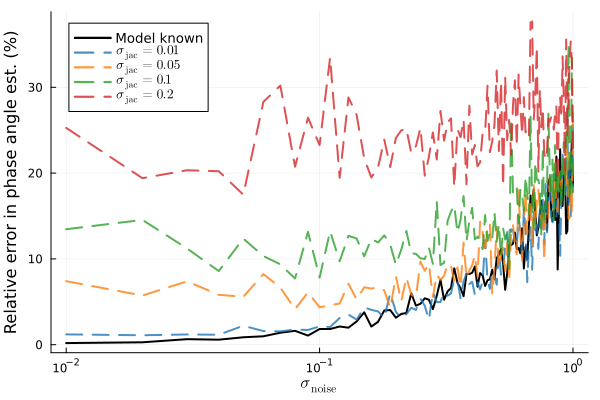

In [115]:
@df ThetaRelErr plot(:sigma_noise,[:mb,:mf_sigma_1,:mf_sigma_2,:mf_sigma_3,:mf_sigma_4],
    label=["Model known" L"$\sigma_{\mathrm{jac}}  = 0.01$" L"$\sigma_{\mathrm{jac}}= 0.05$" L"$\sigma_{\mathrm{jac}}= 0.1$" L"$\sigma_{\mathrm{jac}}= 0.2$"],
    xlabel=L"$\sigma_{\mathrm{noise}}$",ylabel="Relative error in phase angle est. (%)",
    lw=2,
    legend=:topleft,
    color= [:black color_scheme[1] color_scheme[2] color_scheme[3] color_scheme[4]],
    alpha=[1 0.8 0.8 0.8 0.8],
    ls = [:solid :dash :dash :dash :dash],
    legendfontsize=9,
    xscale=:log10)

## Perform Bootstraping

In [26]:
# Make a tensor for repeated sampling of the relative error for each noise level
num_bootstraps = 20
sigma_jac = [0.01, 0.025, 0.05]
sigma_noise = 0.01:0.025:1
ThetaRelErr = zeros(length(sigma_noise),num_bootstraps,length(sigma_jac)+1) 

for repeat_idx in 1:num_bootstraps
    for (sig_idx,σ_jac) in enumerate([0;sigma_jac])
        model_sig_rel_err = []
        for σ_noise in sigma_noise
            if sig_idx == 1
                res = est_model_based_voltage_phase(σ_noise)
            else
                res = est_model_free_voltage_phase!(net,sigma_noise=σ_noise,sigma_jac=σ_jac)
            end
            push!(model_sig_rel_err,res["th_rel_err"])
        end
        ThetaRelErr[:,repeat_idx,sig_idx] = model_sig_rel_err
    end
    println("Completed: repeat_idx = $(repeat_idx)")
end

Completed: repeat_idx = 1


Completed: repeat_idx = 2


Completed: repeat_idx = 3


Completed: repeat_idx = 4


Completed: repeat_idx = 5


Completed: repeat_idx = 6


Completed: repeat_idx = 7


Completed: repeat_idx = 8


Completed: repeat_idx = 9


Completed: repeat_idx = 10


Completed: repeat_idx = 11


Completed: repeat_idx = 12


Completed: repeat_idx = 13


Completed: repeat_idx = 14


Completed: repeat_idx = 15


Completed: repeat_idx = 16


Completed: repeat_idx = 17


Completed: repeat_idx = 18


Completed: repeat_idx = 19


Completed: repeat_idx = 20


In [24]:
ThetaRelErr[:,25,:]

40×4 Matrix{Float64}:
  0.270079   0.222987   0.938639   7.09874
  0.651505   0.77862    1.58532    5.85683
  0.814379   1.18151    1.25279    5.20388
  1.56401    1.82452    1.81338    5.75907
  2.21574    2.4931     1.85076    8.38032
  2.88983    2.77915    3.41946    6.30182
  3.15627    4.68835    3.69249    5.0494
  3.78225    4.03363    2.52239    5.26455
  2.82475    3.53163    4.41251    7.54761
  3.53432    3.55429    5.84832   10.2301
  ⋮                               
 14.5336    16.9046    20.8943    16.0324
 13.1603    11.3874    14.4783    14.9796
 20.0073    15.3923    14.3843    17.3221
 15.1877    16.7079    17.115     17.4818
 17.0947    13.4934    23.0003    15.4495
 13.0905    20.0389    11.3539    18.3842
 16.6924    14.951     20.7723    17.7562
 12.686     14.6143    23.1996    13.9079
 17.3685    23.3924    19.4293    16.9421

### Plot the bootstrapped comparison

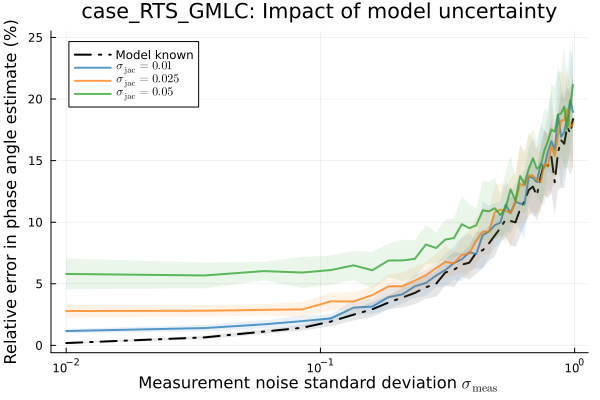

In [27]:
figci = errorline(
    sigma_noise,
    ThetaRelErr, # Tensor of relative error
    label=["Model known" L"$\sigma_{\mathrm{jac}}  = 0.01$" L"$\sigma_{\mathrm{jac}}= 0.025$" L"$\sigma_{\mathrm{jac}}= 0.05$" L"$\sigma_{\mathrm{jac}}= 0.2$"],
    xlabel=L"Measurement noise standard deviation $\sigma_{\mathrm{meas}}$",ylabel="Relative error in phase angle estimate (%)",
    error_style=:ribbon,
    centertype=:mean,
    errortype=:std,
    lw=2,
    groupcolor=[:black color_scheme[1] color_scheme[2] color_scheme[3] color_scheme[4]],
    alpha=[1 0.75 0.75 0.75 0.75],
    ls=[:dashdot :solid :solid :solid :solid],
    xscale=:log10,
    title="case_RTS_GMLC: Impact of model uncertainty",
)

In [28]:
savefig(figci,"../figures/with-without-topology/phase-estimation-error_v3_withTitle.pdf")

"/home/sam/Research/PowerPhaseRetrieval/figures/with-without-topology/phase-estimation-error_v3_withTitle.pdf"